In [1]:
CS 457 Jaewon Heo 44313181 Lab6 - MNIST

SyntaxError: invalid syntax (4023415319.py, line 1)

In [3]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# preparing transformation, training set, testing set 

# defining tramsformation for images
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST dataset has 60,000 training images, and 10,000 test images.
# images will be handwritten digits from 0-9, with size of 28x28 pixels in grayscale.
# since there are 0-9 digits,so total 10 classes. 

# downloading training and testing sets
d_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
d_test = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# creating dataset and dataloader

l_train = DataLoader(d_train, batch_size=64, shuffle=True)
l_test = DataLoader(d_test, batch_size=64, shuffle=True) # validation

In [5]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize the images
    np_img = img.numpy() # converting pytorch tensor to numpy array
    plt.axis("off") 
    plt.title("Jay visualizing data")
    plt.imshow(np.transpose(np_img, (1, 2, 0))) # transposing image dimensions
    plt.show()


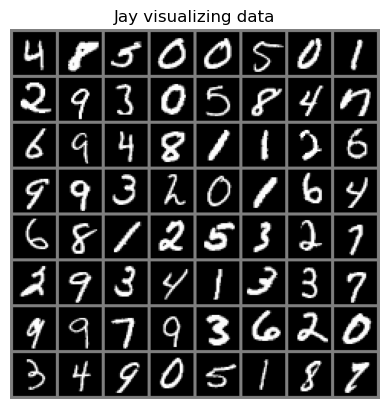

In [9]:
dataiter = iter(l_train)  # Create an iterator
images, labels = next(dataiter)  # Get the next batch of data
imshow(torchvision.utils.make_grid(images))  # Visualize the batch of images

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # First convolutional layer
            
            nn.Conv2d(1, 32, kernel_size=3, padding=1), # 1 input channel, 32 output channels
            # (32 + 2*1 - 1)/(1) + 1 = 32 
            nn.ReLU(),
            
            # Second convolutional layer
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32 input channels, 64 output channels
            # (32 + 2*1 -1)/(1) + 1 = 32
            nn.ReLU(),
            
            # Max pooling layer
            
            nn.MaxPool2d(2) # Pooling with a 2x2 kernel, reducing spatial size by 2
        )
        
        # Fully connected layers
        
        self.fc1 = nn.Linear(64 * 14 * 14, 128) # Flattened 64 channels of 14x14 images
        self.fc2 = nn.Linear(128, 10) # 128 features to 10 classes for MNIST
    
    def forward(self, x):
        
        x = self.main(x)
        x = x.view(x.size(0), -1) # Flatten the tensor (batch_size, 64*14*14)
        x = torch.relu(self.fc1(x)) # First fully connected layer with ReLU
        x = self.fc2(x) # Output layer, no activation function since softmax applied in loss 
        return x

# Setting up the model
model = CNN().to(device)

# Setting up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Summarizing the model
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Linear-6                  [-1, 128]       1,605,760
            Linear-7                   [-1, 10]           1,290
Total params: 1,625,866
Trainable params: 1,625,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.25
Params size (MB): 6.20
Estimated Total Size (MB): 7.45
----------------------------------------------------------------


In [13]:
# training model

epochs = 50

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train() # training starts
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in l_train: # batch of images, and labels that corresponding to images
        optimizer.zero_grad() # zero the gradient
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels)  # computing loss between prediction and actual
        loss.backward() # backward propagation
        optimizer.step() # updating model parameters using optimizer

        running_loss += loss.item() # accumulate batch loss
        _, predicted = torch.max(outputs.data, 1) # acquiring highest score for each ppredicted class
        total_train += labels.size(0)  # counting total number of train
        correct_train += (predicted == labels).sum().item() # takes the number of correct prediction

    train_loss = running_loss / len(l_train) # taking average loss during training
    train_accuracy = 100 * correct_train / total_train # calculating accuracy during training
    train_losses.append(train_loss) # saving calculated loss to the list
    train_accuracies.append(train_accuracy) # saving accuracies to the list

    # Testing phase
    model.eval()
    correct_test = 0
    total_test = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in l_test: # batch of images, and corresponding labels.
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # calculating loss between prediction and actual
            running_loss += loss.item() # accumulating loss
            _, predicted = torch.max(outputs.data, 1) # acquiring highest score for each prediction
            total_test += labels.size(0) # counting total number of testing
            correct_test += (predicted == labels).sum().item() # counting correct outputs 

    test_loss = running_loss / len(l_test) # taking average loss
    test_accuracy = 100 * correct_test / total_test # calculating accuracy over testing
    test_losses.append(test_loss) # saving avegage loss to the list
    test_accuracies.append(test_accuracy) # saving accuracy to the list

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/50, Train Loss: 0.1578, Test Loss: 0.0424, Train Accuracy: 95.40%, Test Accuracy: 98.68%
Epoch 2/50, Train Loss: 0.0424, Test Loss: 0.0221, Train Accuracy: 98.69%, Test Accuracy: 99.31%
Epoch 3/50, Train Loss: 0.0272, Test Loss: 0.0176, Train Accuracy: 99.14%, Test Accuracy: 99.47%
Epoch 4/50, Train Loss: 0.0182, Test Loss: 0.0090, Train Accuracy: 99.41%, Test Accuracy: 99.71%
Epoch 5/50, Train Loss: 0.0126, Test Loss: 0.0139, Train Accuracy: 99.59%, Test Accuracy: 99.50%
Epoch 6/50, Train Loss: 0.0105, Test Loss: 0.0045, Train Accuracy: 99.63%, Test Accuracy: 99.86%
Epoch 7/50, Train Loss: 0.0082, Test Loss: 0.0087, Train Accuracy: 99.75%, Test Accuracy: 99.69%
Epoch 8/50, Train Loss: 0.0072, Test Loss: 0.0022, Train Accuracy: 99.77%, Test Accuracy: 99.92%
Epoch 9/50, Train Loss: 0.0063, Test Loss: 0.0096, Train Accuracy: 99.78%, Test Accuracy: 99.70%
Epoch 10/50, Train Loss: 0.0055, Test Loss: 0.0065, Train Accuracy: 99.80%, Test Accuracy: 99.78%
Epoch 11/50, Train Loss: 0.00

In [ ]:
# based on the train accuracy, it seems the model trained extremely well. 

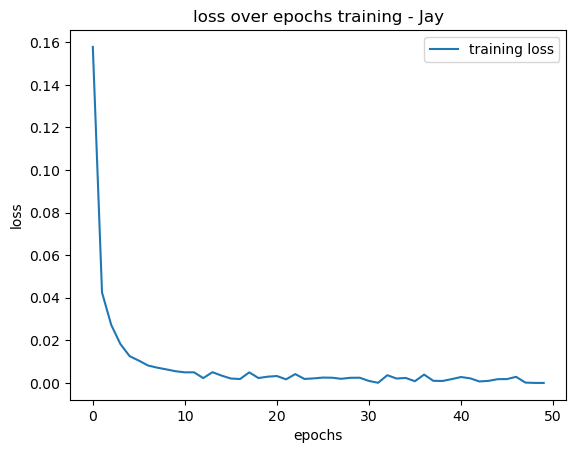

In [15]:
# visualizing training loss
plt.plot(train_losses, label="training loss")
plt.title("loss over epochs training - Jay")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# training loss is steadily decreasing. 

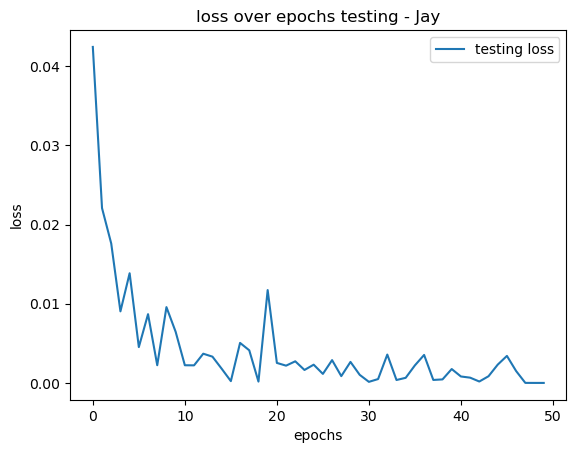

In [17]:
# visualizing testing loss
plt.plot(test_losses, label="testing loss")
plt.title("loss over epochs testing - Jay")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# testing loss seems to have minor fluctuation over testing. expecually between epoch 17-20.
# however, this doesn't means it is overfitted. 

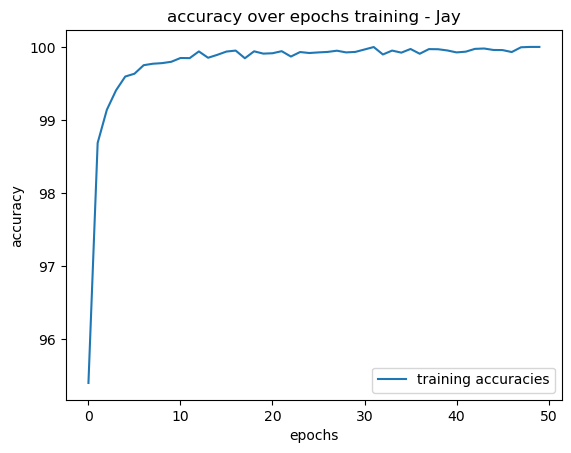

In [19]:
# visualizing training accuracy
plt.plot(train_accuracies,label="training accuracies")
plt.title("accuracy over epochs training - Jay")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# training accuracy is stadily increasing until 100%

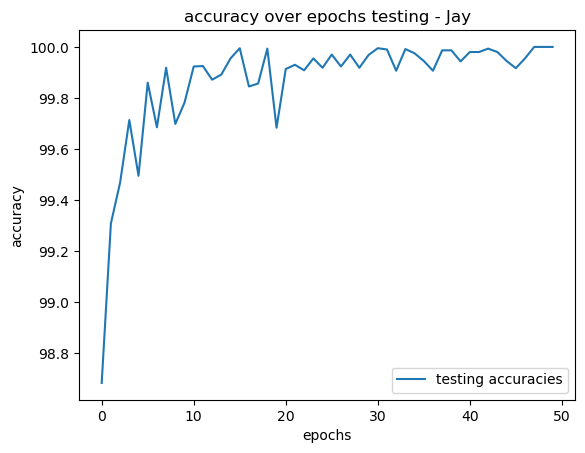

In [21]:
# visualizing testing accuracy
plt.plot(test_accuracies, label="testing accuracies")
plt.title("accuracy over epochs testing - Jay")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

# testing accuracy is also showing minor fluctuation as testing loss, but there is no sign of overfitting. 

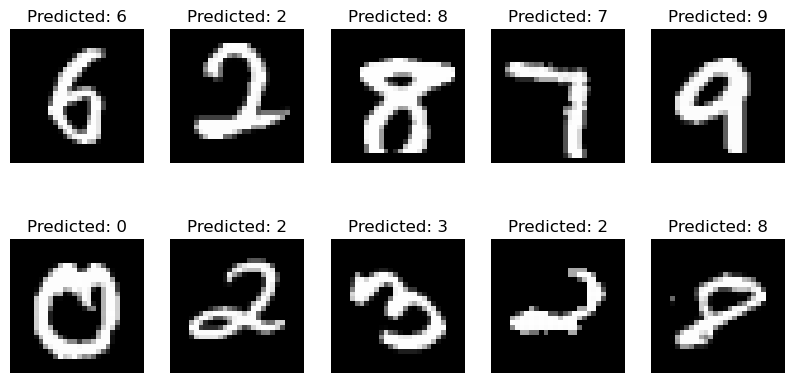

In [23]:
# visualizing predictions
model.eval() # Set the model to evaluation mode
dataiter = iter(l_test) # Create an iterator from the DataLoader
images, labels = next(dataiter) # Use next() to get the next batch of data
outputs = model(images) # Pass the images through the model
_, predicted = torch.max(outputs.data, 1) # Get the predicted class labels

# Plotting the results
fig = plt.figure(figsize=(10, 5)) # Correct the typo `fugure` to `figure`
for i in range(10): # Loop through the first 10 images
    ax = fig.add_subplot(2, 5, i+1) # Create a subplot in a 2x5 grid
    ax.imshow(images[i].numpy().squeeze(), cmap='gray') # Show the image
    ax.set_title(f"Predicted: {predicted[i].item()}") # Show the predicted label
    ax.axis("off") # Hide the axis

plt.show() # Display the plot

In [27]:
# saving model
torch.save(model.state_dict(), "saved.pt")